## Barotropic streamfunction

Compared with data from [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1)

Based on
https://github.com/OceansAus/cosima-cookbook/blob/master/ContributedExamples/BarotropicStreamFunction.ipynb

Set `ekey` below to plot different experiments.

In [1]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib
Available exptdata keys:  ['1deg_v1', '025deg_v1', '01deg_v1', '1deg_v2', '025deg_v2', '01deg_v2']


In [2]:
import climtas.nci
climtas.nci.GadiClient()

Client Scheduler: tcp://127.0.0.1:46501 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 256.00 GiB


In [3]:
session = cc.database.create_session()

In [4]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [5]:
firstyear = tstart.year  # assumes tstart is 1 January!
lastyear = tend.year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [6]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

**The function below** calculates the quasi-barotropic streamfunction for each simulation. In each case, we read in only the last IAF cycle, then we average over the standard time period.

In [7]:
def get_gyre_psi(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    cntrl_tx_trans = cc.querying.getvar(expt,'tx_trans_int_z', session,
                                       start_time = str(firstyear),
                                       end_time = str(lastyear))\
                                       .sel(time=slice(tstart,tend))\
                                       .mean('time')
    # convert from kg/s to Sv, assuming typical density of 1036kg/m^3 (underestimates deep ocean)
    cntrl_psi = cntrl_tx_trans.cumsum('yt_ocean')/1e6/1036
    #now find DP transport to subtract for the NAtl psi - see Rong
    cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    gyre_psi = -cntrl_psi+cntrl_dp_ts

    # write to disk
#     gyre_psi.to_netcdf(NOSYNC + expt + '_gyre_psi_' + yearrange +'.nc')
    
    return gyre_psi

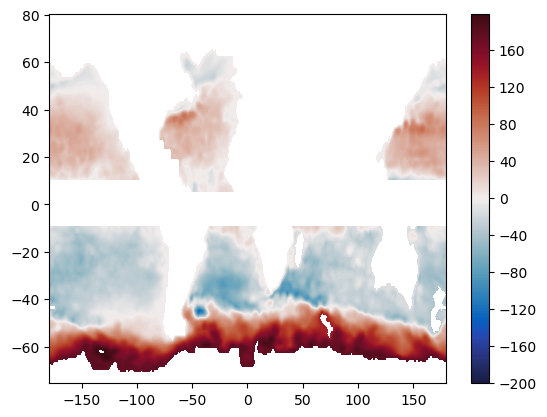

In [8]:
data=loadmat('/g/data3/hh5/tmp/cosima/observations/original/psi_barotropic.mat')
lon = data['lon_p'][0,:]
lat = data['lat_p'][0,:]
psi = data['psi']/1e6 # in Sv
plt.contourf(lon,lat,psi,levels=np.arange(-200,200),cmap = cm.cm.balance)
plt.colorbar()

In [9]:
# General plotting stuff
plot_labels=['(a) ','(b) ','(c) ','(d)','(e)','(f)']
land_50m = cft.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.5)
# cmp = plt.get_cmap('gist_ncar_r')  # confusing with the most common form of colourblindness (deuteranomaly)
cmp = plt.get_cmap('nipy_spectral')

In [10]:
%%time
ekey='1deg_v1'
expt = exptdata.exptdict[ekey]['expt']

sea_level = cc.querying.getvar(expt,'sea_level', session, 
                               start_time = str(firstyear),
                               end_time = str(lastyear)).sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
sea_levelsq = cc.querying.getvar(expt, 'sea_levelsq', session, 
                                start_time = str(firstyear),
                                end_time = str(lastyear))\
                                .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_1deg_v1 = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_1deg_v1.load()

CPU times: user 1.4 s, sys: 106 ms, total: 1.51 s
Wall time: 7.71 s


<xarray.DataArray (yt_ocean: 300, xt_ocean: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77

In [11]:
%%time
ekey='1deg_v2'
expt = exptdata.exptdict[ekey]['expt']

sea_level = cc.querying.getvar(expt,'sea_level', session, 
                               frequency='1 monthly',
                               start_time = str(firstyear),
                               end_time = str(lastyear)).sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
sea_levelsq = cc.querying.getvar(expt, 'sea_level_sq', session, 
                                 frequency='1 monthly',
                                 start_time = str(firstyear),
                                 end_time = str(lastyear))\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_1deg_v2 = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_1deg_v2.load()

CPU times: user 1.63 s, sys: 154 ms, total: 1.79 s
Wall time: 8.3 s


<xarray.DataArray (yt_ocean: 300, xt_ocean: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77

In [12]:
%%time
ekey='025deg_v1'
expt = exptdata.exptdict[ekey]['expt']

sea_level = cc.querying.getvar(expt,'sea_level',session,
                              start_time = str(firstyear),
                              end_time = str(lastyear))\
                              .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
sea_levelsq = cc.querying.getvar(expt,'sea_levelsq',session,
                                start_time = str(firstyear),
                                end_time = str(lastyear))\
                                .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_025deg_v1 = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_025deg_v1.load()

CPU times: user 5.94 s, sys: 260 ms, total: 6.2 s
Wall time: 16.2 s


<xarray.DataArray (yt_ocean: 1080, xt_ocean: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95

In [13]:
%%time
ekey='025deg_v2'
expt = exptdata.exptdict[ekey]['expt']

sea_level = cc.querying.getvar(expt,'sea_level',session,
                               frequency='1 monthly',
                               start_time = str(firstyear),
                               end_time = str(lastyear))\
                               .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
sea_levelsq = cc.querying.getvar(expt,'sea_level_sq',session,
                                 frequency='1 monthly',
                                 start_time = str(firstyear),
                                 end_time = str(lastyear))\
                                .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_025deg_v2 = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_025deg_v2.load()

CPU times: user 48.8 s, sys: 1.63 s, total: 50.5 s
Wall time: 1min 11s


<xarray.DataArray (yt_ocean: 1080, xt_ocean: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95

In [14]:
%%time
ekey='01deg_v1'
expt = exptdata.exptdict[ekey]['expt']

chunks={'xt_ocean': 400, 'yt_ocean': 300}

sea_level = cc.querying.getvar(expt,'eta_t',session,
                               start_time = str(firstyear),
                               end_time = str(lastyear))\
                               .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
sea_levelsq = cc.querying.getvar(expt,'sea_levelsq',session,
                                 start_time = str(firstyear),
                                 end_time = str(lastyear))\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_01deg_v1 = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_01deg_v1.load()

CPU times: user 16min 5s, sys: 22 s, total: 16min 28s
Wall time: 22min 20s


<xarray.DataArray (yt_ocean: 2700, xt_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [15]:
%%time
ekey='01deg_v2'
expt = exptdata.exptdict[ekey]['expt']

chunks={'xt_ocean': 400, 'yt_ocean': 300}

sea_level = cc.querying.getvar(expt,'sea_level',session,
                               ncfile='ocean-2d-sea_level-1-monthly-mean-ym_%.nc',
                               start_time = str(firstyear),
                               end_time = str(lastyear))\
                               .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
sea_levelsq = cc.querying.getvar(expt,'sea_level_sq',session,
                                 ncfile='ocean-2d-sea_level_sq-1-monthly-mean-ym_%.nc',
                                 start_time = str(firstyear),
                                 end_time = str(lastyear))\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_01deg_v2 = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_01deg_v2.load()

CPU times: user 50 s, sys: 1.97 s, total: 51.9 s
Wall time: 1min 42s


<xarray.DataArray (yt_ocean: 2700, xt_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [16]:
aviso_file = '/g/data3/hh5/tmp/cosima/observations/original/AVISO_Mean_Std/aviso_ssh_monthly_anom_clim9314_GMSLtrend_removed.timstd.nc'
SLMA = xr.open_dataset(aviso_file).SLMA.mean('TAXM')

In [17]:
gyre_psi_1deg_v1 = get_gyre_psi('1deg_v1')
gyre_psi_025deg_v1 = get_gyre_psi('025deg_v1')
gyre_psi_01deg_v1 = get_gyre_psi('01deg_v1')

In [18]:
gyre_psi_1deg_v2 = get_gyre_psi('1deg_v2')
gyre_psi_025deg_v2 = get_gyre_psi('025deg_v2')
gyre_psi_01deg_v2 = get_gyre_psi('01deg_v2')

In [19]:
## All data is now loaded - make a dictionary for plotting
gyre_psi_dict = {'1deg_v1': gyre_psi_1deg_v1, '025deg_v1': gyre_psi_025deg_v1, '01deg_v1': gyre_psi_01deg_v1,
                 '1deg_v2': gyre_psi_1deg_v2, '025deg_v2': gyre_psi_025deg_v2, '01deg_v2': gyre_psi_01deg_v2}
sla_rms_dict = {'1deg_v1': sla_rms_1deg_v1, '025deg_v1': sla_rms_025deg_v1, '01deg_v1': sla_rms_01deg_v1,
                '1deg_v2': sla_rms_1deg_v2, '025deg_v2': sla_rms_025deg_v2, '01deg_v2': sla_rms_01deg_v2}
# gyre_psi_dict = {'1deg': gyre_psi_1deg} #, '025deg': gyre_psi_025deg, '01deg': gyre_psi_01deg}
# sla_rms_dict = {'1deg': sla_rms_1deg} #, '025deg': sla_rms_025deg, '01deg': sla_rms_01deg}

In [20]:
# EAC Region
plt.figure(figsize(12,6))
clev = np.arange(0,0.351,0.01)
clev2 = np.arange(-50,150.01,5)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    sla_rms = sla_rms_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,3,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-220, -160, -52, -20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
    gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
    gl.xlabels_top = False
    gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
    gl.xlabels_top = False
    gl.ylabels_right = False
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])
    
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')
savefigure('eac_barotropic_streamfunctions_Comparison_cycle1')

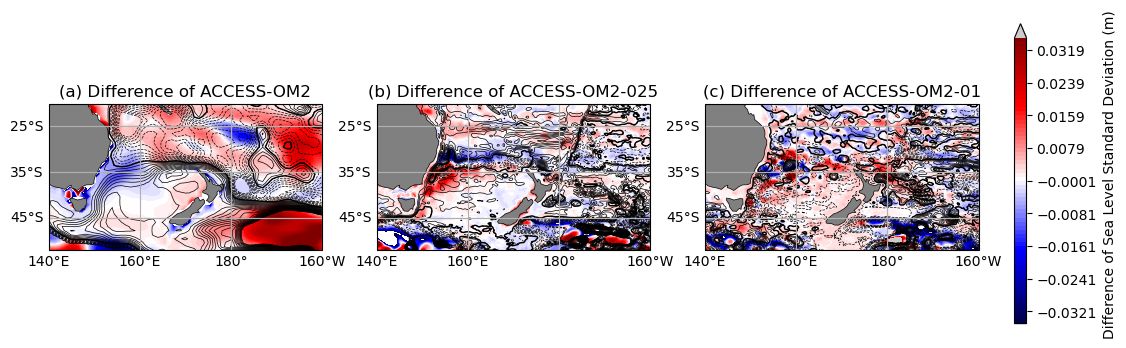

In [21]:
plt.figure(figsize(12,6))
clev = np.arange(-0.0351,0.0351,0.001)
clev2 = np.arange(-5,15.01,0.55)

ax = plt.subplot(1,3,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-220, -160, -52, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
gl.xlabels_top = False
gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
gl.xlabels_top = False
gl.ylabels_right = False
p1= (sla_rms_dict['1deg_v2']- sla_rms_dict['1deg_v1']).plot.contourf(cmap='seismic', levels=clev, extend='both', 
                                                                     add_colorbar=False, transform=ccrs.PlateCarree())
p1.cmap.set_over(color=cmp(255), alpha=None)
(gyre_psi_dict['1deg_v2']-gyre_psi_dict['1deg_v1']).plot.contour(levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
(gyre_psi_dict['1deg_v2']-gyre_psi_dict['1deg_v1']).plot.contour(levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(a) Difference of ACCESS-OM2')



ax = plt.subplot(1,3,2,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-220, -160, -52, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
gl.xlabels_top = False
gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
gl.xlabels_top = False
gl.ylabels_right = False
p1= (sla_rms_dict['025deg_v2']- sla_rms_dict['025deg_v1']).plot.contourf(cmap='seismic', levels=clev, extend='both', 
                                                                     add_colorbar=False, transform=ccrs.PlateCarree())
p1.cmap.set_over(color=cmp(255), alpha=None)
(gyre_psi_dict['025deg_v2']-gyre_psi_dict['025deg_v1']).plot.contour(levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
(gyre_psi_dict['025deg_v2']-gyre_psi_dict['025deg_v1']).plot.contour(levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(b) Difference of ACCESS-OM2-025')



ax = plt.subplot(1,3,3,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-220, -160, -52, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
gl.xlabels_top = False
gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
gl.xlabels_top = False
gl.ylabels_right = False
p1= (sla_rms_dict['01deg_v2']- sla_rms_dict['01deg_v1']).plot.contourf(cmap='seismic', levels=clev, extend='both', 
                                                                     add_colorbar=False, transform=ccrs.PlateCarree())
p1.cmap.set_over(color=cmp(255), alpha=None)
(gyre_psi_dict['01deg_v2']-gyre_psi_dict['01deg_v1']).plot.contour(levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
(gyre_psi_dict['01deg_v2']-gyre_psi_dict['01deg_v1']).plot.contour(levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(c) Difference of ACCESS-OM2-01')


ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Difference of Sea Level Standard Deviation (m)')
savefigure('eac_barotropic_streamfunctions_difference_cycle1')